In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY','ca01b8248b7b469db2028f654742009e')
print(key)

ca01b8248b7b469db2028f654742009e


In [45]:
 def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params, verify=True)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [59]:
results = search_images_bing(key, 'Grizzly bear', min_sz=128)
ims = results.attrgot('contentUrl')
len(ims)

150

In [68]:
ims[0]='http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg'

In [69]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest, overwrite=True)

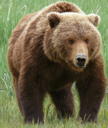

In [70]:
im = Image.open(dest)
im.to_thumb(128,128)

In [72]:
bear_types = 'grizzly','black','teddy'
path = Path('images/bears')

In [73]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [74]:
fns = get_image_files(path)
fns

(#445) [Path('images/bears/grizzly/00000001.jpg'),Path('images/bears/grizzly/00000005.jpg'),Path('images/bears/grizzly/00000003.jpg'),Path('images/bears/grizzly/00000009.jpg'),Path('images/bears/grizzly/00000007.jpg'),Path('images/bears/grizzly/00000012.jpg'),Path('images/bears/grizzly/00000013.jpg'),Path('images/bears/grizzly/00000002.jpg'),Path('images/bears/grizzly/00000010.jpg'),Path('images/bears/grizzly/00000014.jpg')...]

In [75]:
failed = verify_images(fns)
failed

(#4) [Path('images/bears/grizzly/00000066.jpg'),Path('images/bears/grizzly/00000144.jpg'),Path('images/bears/teddy/00000031.jpg'),Path('images/bears/teddy/00000140.jpg')]

In [76]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

Function signature:

In [90]:
?verify_images

Function source:

In [89]:
??verify_images

Function documentation:

In [91]:
doc(verify_images)

Python debugger:

### End sidebar

## From Data to DataLoaders

In [77]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [78]:
dls = bears.dataloaders(path)

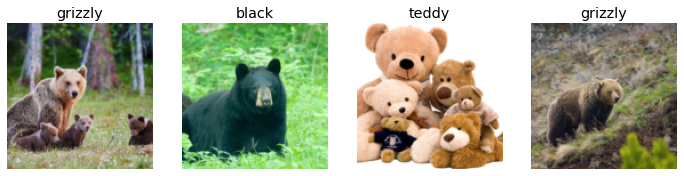

In [79]:
dls.valid.show_batch(max_n=4, nrows=1)

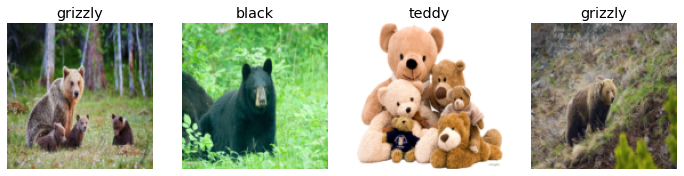

In [81]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

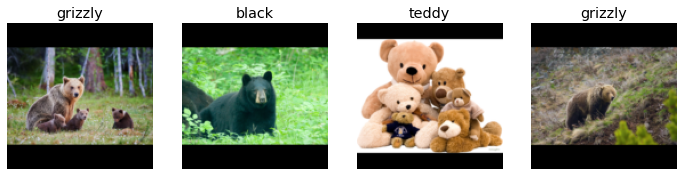

In [80]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

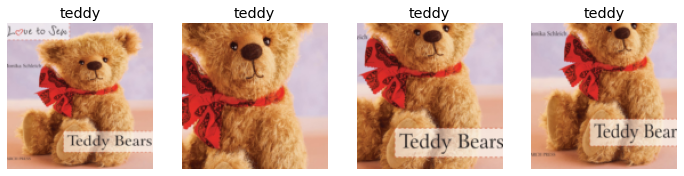

In [82]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

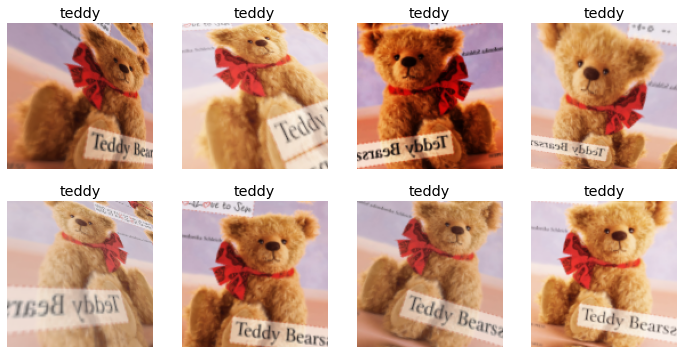

In [83]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [84]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [85]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.293875,0.114641,0.045455,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.157862,0.079312,0.022727,00:10
1,0.092953,0.063022,0.034091,00:11
2,0.072879,0.063267,0.022727,00:11
3,0.057454,0.064346,0.022727,00:11


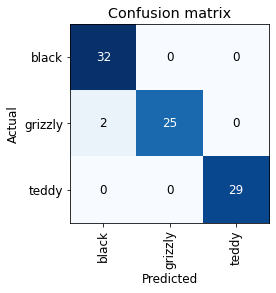

In [86]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

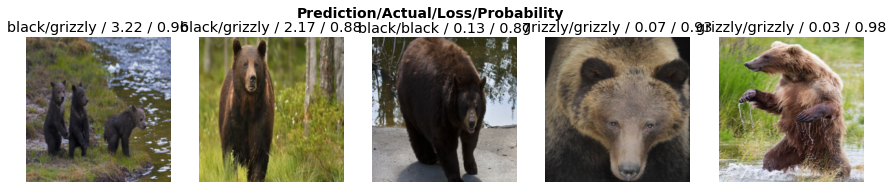

In [87]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/grizzly.jpg')

In [ ]:
learn_inf.dls.vocab

### Creating a Notebook App from the Model

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
    * _Problems could occur due to out-of-domain data, where the data the model sees in production is very different to what it saw during training. For example, there may be images of bears in positions that are rarely seen in photos that people post online._
1. Where do text models currently have a major deficiency?
    * _Deep learning is currently not good at generating correct responses to queries._
1. What are possible negative societal implications of text generation models?
    * _Context-appropriate, highly compelling responses on social media could be used at massive scale to spread disinformation, create unrest, and encourage conflict_
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
    * _Run as a manual process first (where the human checks all outputs), then move to limtied scope, then gradual expansion_
1. What kind of tabular data is deep learning particularly good at?
    * _Data with high-cardinality categorical columns _
1. What's a key downside of directly using a deep learning model for recommendation systems?
    * _The model will generate predictions of what the user might like, not recommended actions._
1. What are the steps of the Drivetrain Approach?
    * _Defined objective, levers (what inputs we can control), data (what information we can collect) and models (how the levers influence the objective). _
1. How do the steps of the Drivetrain Approach map to a recommendation system?
    * _ Objective: drive additional sales through recommendations, lever: ranking of the recommendations, data: sales history, models: build two different models for purchase probabilites conditional on seeing or not seeing the recommendation._
1. Create an image recognition model using data you curate, and deploy it on the web.
    * _TODO_ 
1. What is `DataLoaders`?
    * _a class that stores whatever DataLoader objects you pass to it, and makes them available as training and validation sets._
1. What four things do we need to tell fastai to create `DataLoaders`?
    * _What kinds of data we are working with, how to get the list of items, how to label these items and how to create the validation set._
1. What does the `splitter` parameter to `DataBlock` do?
    * _How to split the data into a validation and test set._
1. How do we ensure a random split always gives the same validation set?
    * _By providing a seed._
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.